<a href="https://colab.research.google.com/github/chrisrichardson/minidolfin/blob/master/minidolfin_elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
!pip3 install numba>=0.49 --upgrade
!pip3 install pyamg
!pip3 -q install git+https://github.com/FEniCS/FIAT.git --upgrade
!pip3 -q install git+https://github.com/FEniCS/ufl.git --upgrade
!pip3 -q install git+https://github.com/FEniCS/ffcx.git --upgrade
!pip3 -q install git+https://github.com/chrisrichardson/minidolfin.git --upgrade

     |████████████████████████████████| 6.4MB 2.4MB/s 
     |████████████████████████████████| 296kB 41.8MB/s 
     |████████████████████████████████| 153kB 2.7MB/s 


In [ ]:
import numba
numba.__version__

'0.51.2'

__Elasticity equation__

In this demo, we will solve the equation $\nabla\cdot\sigma(u) = 0$ subject to enforced boundary conditions on certain parts of a square domain. 


In [18]:
import ufl
import numpy
import scipy.sparse.linalg
 
from minidolfin.meshing import build_unit_square_mesh
from minidolfin.dofmap import build_dofmap
from minidolfin.dofmap import interpolate_vertex_values
from minidolfin.assembling import assemble
from minidolfin.bcs import build_dirichlet_dofs
from minidolfin.bcs import bc_apply
from minidolfin.plot import plot
 
# UFL form
element = ufl.VectorElement("P", ufl.triangle, 1)
u, v = ufl.TrialFunction(element), ufl.TestFunction(element)

E = 10.0
nu = 0.25
mu = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))


def epsilon(v):
    return 0.5*(ufl.grad(v) + ufl.grad(v).T)


def sigma(v):
    return 2.0*mu*epsilon(v) + lmbda*ufl.tr(epsilon(v)) \
        * ufl.Identity(v.geometric_dimension())


a = ufl.inner(sigma(u), epsilon(v))*ufl.dx
 
# Build mesh                      
n = 50                                              
mesh = build_unit_square_mesh(n, n)
tdim = mesh.reference_cell.get_dimension()
print('Number of cells: {}'.format(mesh.num_entities(tdim)))
 
# Build dofmap                                                                  
dofmap = build_dofmap(element, mesh)
print('Number of dofs: {}'.format(dofmap.dim))
 
# Run and time assembly                                                       
A = assemble(dofmap, a, dtype=numpy.float64)
 
# Prepare solution and rhs vectors and apply boundary conditions
x = numpy.zeros(A.shape[1], dtype=A.dtype)
b = numpy.zeros_like(x)
 
# Set Dirichlet BCs
bc_dofs = list(range(n*2 + 2)) + [len(b) - n - 1]
bc_vals = numpy.zeros_like(bc_dofs, dtype=A.dtype)
bc_vals[-1] = -0.01

print(bc_vals.dtype)
bc_apply(bc_dofs, bc_vals, A, b)
 
# Solve linear system
x = scipy.sparse.linalg.spsolve(A, b)
 
r = (A*x - b)
print(r.max(), r.min())
x = x.reshape((-1, 2))

Number of cells: 5000
Number of dofs: 5202
float64
1.249000902703301e-16 -1.5959455978986625e-16


__Visualisation__

Plot the magnitude and displacement of the solution.

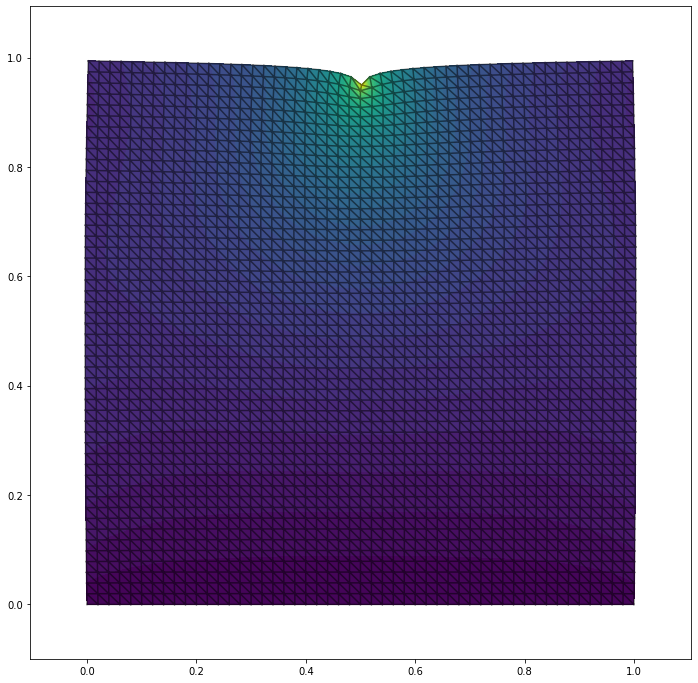

In [19]:
%matplotlib inline
from matplotlib import tri
import matplotlib.pyplot as plt
 
# Plot solution
xmag = numpy.sqrt(x[:,0]**2 + x[:,1]**2)
mesh.vertices += x*5
plt.figure(figsize=(12,12))
plot(mesh, xmag)
plt.show()